In [16]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import numpy.fft as fft
from IPython.display import Audio

In [17]:
def hann(N):
    n = np.arange(0, N)
    return 0.5 - 0.5*np.cos((2 * np.pi * n) / (N - 1))

def hamming(N):
    n = np.arange(0, N)
    h = 0.54 - 0.46*np.cos((2 * np.pi * n) / (N - 1)) 
    h[0] /= 2
    h[-1] /= 2
    return h

def rectangular(N):
    return np.ones(N)

In [18]:
def chunks(data, chunk_size, hop_size):
    for begin in range(0, len(data), hop_size):
        yield data[begin:begin+chunk_size], begin

In [19]:
def h(L, f_c, f_s):
    H = np.zeros(L)
    for k in range(L):
        if k == ((L - 1) / 2):
            H[k] = (2 * f_c) / f_s
        else:
            H[k] = np.sin(((2 * np.pi * f_c) / f_s) * (k - ((L - 1) / 2))) / (np.pi*(k - ((L - 1) / 2)))
    return H

import librosa
import librosa.display

def compare_wave_spectra(original, filtered):

    fig, ax = plt.subplots(1, 2, figsize = (8, 6))
    
    D = librosa.stft(original)  
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, sr = 44100, x_axis='time', y_axis='log', ax = ax[0])


    D = librosa.stft(filtered)  
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, sr = 44100, x_axis='time', y_axis='log', ax = ax[1])

    plt.show()


(220551,) (220551,) 0 270551


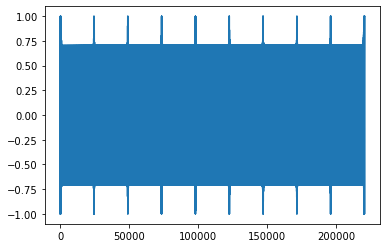

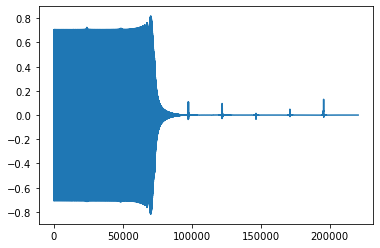

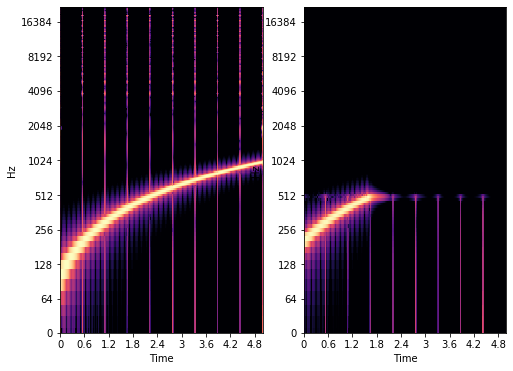

In [20]:
from numba import njit

x, f_s = sf.read("chirp_100Hz_1000Hz_lin.wav", dtype='float64')

Audio(x, rate=f_s)

def window_method(x, L=59, f_c=500, f_s=44100, windowing_func=None):
    assert windowing_func in ["hann", "hamming", "rectangular", None]
    w_fn = {
        "hann":hann,
        "hamming":hamming,
        "rectangular":rectangular,
        None: lambda x: x
    }
    padded_x = np.pad(x, (L-1, 0), 'constant', constant_values=(0, 0))
    out = np.zeros_like(padded_x)
    
    H = h(L, f_c = f_c, f_s = f_s)
    H *= w_fn[windowing_func](len(H))

    return np.convolve(padded_x, H)
    #return _window_calculate(H, padded_x, L, out)
    

@njit
def _window_calculate(H, padded_x, L, out):
    for n in range(len(padded_x)):
        s = 0
        for k in range(L):
            s += padded_x[n - k]*H[k]
        out[n] = s
    return out


L = 50001
out = window_method(x, L=L, f_c=500, f_s=f_s, windowing_func="hann")
out = out[out.shape[0] - x.shape[0]:]
print(x.shape, out.shape, out.shape[0] - x.shape[0], x.shape[0] + L - 1 )

plt.plot(x)
plt.show()
plt.plot(out)
plt.show()
compare_wave_spectra(x, out)

In [6]:
Audio(out, rate=f_s)

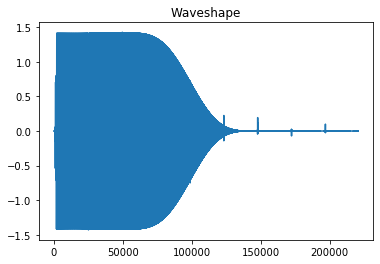

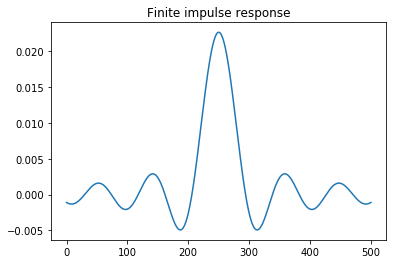

In [21]:
x, f_s = sf.read("chirp_100Hz_1000Hz_lin.wav", dtype='float64')

L = 501
cutoff = 500
chunk_size = 2 * 1024
hop_size = chunk_size//2
out = np.zeros_like(x)
#out = []

H = h(L, f_c = cutoff, f_s = f_s)

for chunk, begin in chunks(x, chunk_size=chunk_size, hop_size=hop_size):
    window_result = window_method(chunk, L, f_c=cutoff, f_s=f_s, windowing_func = "hamming")
    out[begin : begin + len(window_result)] += window_result[:len(out[begin : begin + len(window_result)])]
    
    
plt.title("Waveshape")  
plt.plot(out)
#plt.xlim(40000, 50000)
plt.show()
plt.title("Finite impulse response")
plt.plot(H)
plt.show()
Audio(out, rate=f_s)
#sf.write("chirp_100Hz_1000Hz_lin_filtered_chunks.wav",out, f_s)

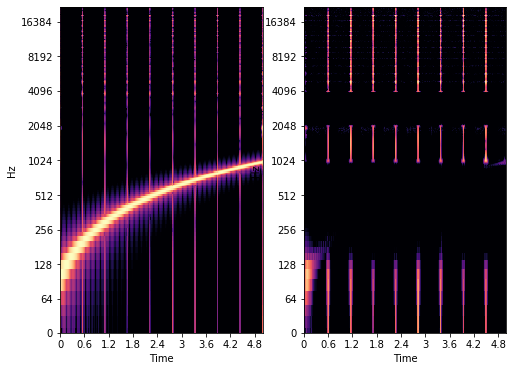

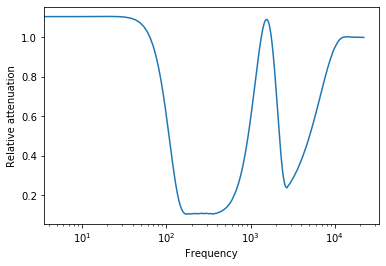

In [15]:
%matplotlib inline
x, f_s = sf.read("chirp_100Hz_1000Hz_lin.wav", dtype='float64')

def ideal_lowpass(nfilt, f_c, f_s):
    return np.sin(2 * np.pi * f_c * nfilt / f_s) / (np.pi * nfilt)

def ideal_highpass(nfilt, f_c, f_s):
    hipass_freq = np.pi - (2 * np.pi * f_c / f_s)
    return ((-1) ** np.arange(len(nfilt))) * (np.sin(hipass_freq * nfilt) / (np.pi * nfilt))

def ideal_bandpass(nfilt, f_l, f_h, f_s):
    w_l = 2 * np.pi * f_l / f_s
    w_h = 2 * np.pi * f_h / f_s
    w_middle = (w_l + w_h)/ 2
    w_width = (w_l - w_h) / 2
    h_lpf = np.sin(w_width * nfilt) / (np.pi * nfilt)
    
    return 2 * np.cos(w_middle * nfilt) * h_lpf

def window_method_v2(x, filter_func, L = 501):
    Nsig = len(x)
    M = L #nominal window length
    Nfft = (int) (2**(np.ceil(np.log2(M + L - 1)))) # FFT length
    M = Nfft - L + 1  #efficient window length
    R = M//2 #hann window hop size
    Nframes = (int) (1 + np.floor((Nsig - M)/R)) #n of complete frames

    nfilt = np.arange(-(L-1)/2, (L-1)/2 + 1) + 1e-9

    h_ideal = filter_func(nfilt)
    w = hann(L)
    h = w.conj().T * h_ideal
    hzp = np.pad(h, (0, Nfft - L), 'constant', constant_values=(0, 0))
    H = fft.fft(hzp)
    y = np.zeros(Nsig + Nfft)
    for m in range(Nframes + 1):
        start, end = m*R+1, min(m*R + M, Nsig)
        xm = x[start: end] * hann(len(x[start: end]))
        xmzp = np.pad(xm, (0, Nfft - len(xm)), 'constant', constant_values=(0, 0))
        Xm = fft.fft(xmzp)
        Ym = Xm * H
        ym = fft.ifft(Ym).real
        out_start, out_end = m*R+1, m*R+Nfft+1
        y[out_start: out_end] += ym
    y = y[: len(x)]
    return y


def frequency_method(x, filter_func, L = 501):
    chunk_size = 8 * 1024
    hop_size = chunk_size//2
    out = np.zeros_like(x)

    for chunk, begin in chunks(x, chunk_size=chunk_size, hop_size=hop_size):
        nfilt = np.arange(-(L-1)/2, (L-1)/2 + 1) + 1e-9
        H = filter_func(nfilt)
        N = len(chunk) + L - 1
        H *= hann(len(H))

        padded_chunk = np.pad(chunk, (N - len(chunk), 0), 'constant', constant_values=(0, 0))
        padded_h = np.pad(H, (N - L, 0), 'constant', constant_values=(0, 0))

        window_spectrum = fft.fft(padded_chunk)[:len(padded_chunk)]
        h_spectrum = fft.fft(padded_h)

        product = window_spectrum * h_spectrum
        inverse = fft.ifft(product, len(padded_chunk)).real 
        out[begin : begin + len(inverse)] += inverse[:len(out[begin : begin + len(inverse)])] 
    return out


filter_stack = (
    [
        lambda nfilt: ideal_lowpass(nfilt, 100, f_s),
        lambda nfilt: ideal_bandpass(nfilt, 1024, 2048, f_s), 
        lambda nfilt: ideal_highpass(nfilt, 4096, f_s)
    ], 
    [
        5001,
        5001,
        5001
    ])

y = np.zeros_like(x)
for f, L in zip(*filter_stack):
    y += window_method_v2(x, f, L)
    
compare_wave_spectra(x, y)

def filter_shape_from_impulse_response(x, filters, Ls):
    filter_spectra = []
    
    Nffts = []
    for filter_func, L in zip(filters, Ls):
        Nsig = len(x)
        M = 4 * L #nominal window length
        Nfft = (int) (2**(np.ceil(np.log2(M + L - 1))))# FFT length
        Nffts.append(Nfft)
    
    Nfft = max(Nffts)
    
    for filter_func, L in zip(filters, Ls):
        nfilt = np.arange(-(L-1)/2, (L-1)/2 + 1) + 1e-9

        h_ideal = filter_func(nfilt) #ideal_bandpass(nfilt, 256, 1024, f_s) + ideal_highpass(nfilt, 2048, f_s) + ideal_lowpass(nfilt, 128, f_s)
        w = hamming(L)
        h = w.conj().T * h_ideal
        hzp = np.pad(h, (0, Nfft - L), 'constant', constant_values=(0, 0))
        H = fft.rfft(hzp) # len(H) = len(hzp)//2 + 1)
        filter_spectra.append(np.abs(H))
    
    out_spectrum = np.zeros(Nfft//2 + 1)
    for spectrum in filter_spectra:
        out_spectrum += spectrum
    return fft.rfftfreq((out_spectrum.size - 1) * 2, d = 1/f_s), out_spectrum


freqs, spectrum = filter_shape_from_impulse_response(x,
    [
        lambda nfilt: ideal_lowpass(nfilt, 100, f_s),
        lambda nfilt: ideal_bandpass(nfilt, 1024, 2048, f_s), 
        lambda nfilt: ideal_highpass(nfilt, 5000, f_s)
    ], 
    [
        1111,
        111,
        11
    ])
plt.plot(freqs, spectrum)
plt.xscale('log')
plt.ylabel('Relative attenuation')
plt.xlabel('Frequency')
plt.show()

<IPython.core.display.Javascript object>


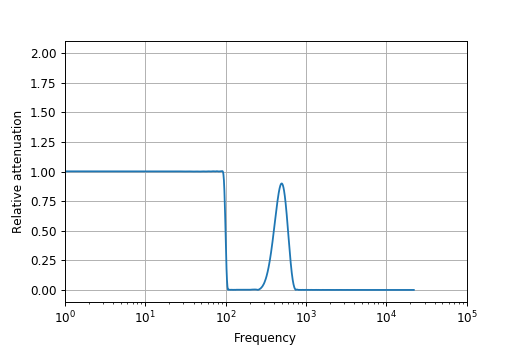

In [22]:
%matplotlib notebook
from copy import deepcopy
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def create_filters(filter_stack):
    xd, Ls = [], []
    for fil in filter_stack.keys():
        fil_num = int(fil.split()[-1])
        typ = filter_stack[fil][f'Type {fil_num}']
        band_values = deepcopy(filter_stack[fil][f'Band {fil_num}'])
        if typ == 'none':
            continue
        elif typ == 'highpass':
            _, hi = deepcopy(band_values)
            xd.append((lambda a, b: lambda nfilt: ideal_highpass(nfilt, a, b))(hi, f_s))
            xd[-1](np.arange(51))
        elif typ == 'lowpass':
            low, _ = deepcopy(band_values)
            xd.append((lambda a, b: lambda nfilt: ideal_lowpass(nfilt, a, b))(low, f_s))
            xd[-1](np.arange(51))
        elif typ == 'bandpass':
            low, hi = deepcopy(band_values)
            xd.append((lambda a, b, c: lambda nfilt: ideal_bandpass(nfilt, a, b, c))(low, hi, f_s))
            xd[-1](np.arange(51))
        
        Ls.append(filter_stack[fil][f'L {fil_num}'])
    return xd, Ls


num_filters = 5
source, f_s = sf.read("chirp_100Hz_1000Hz_lin.wav", dtype='float64')

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xscale('log')
ax.set_xlim(1, 10e4)
ax.set_ylabel('Relative attenuation')
ax.set_xlabel('Frequency')
ax.grid(True)

filter_types = ['none', 'lowpass', 'bandpass', 'highpass']
filter_stack = {
    f'Filter {i}': {
        f'Band {i}': [i * 400 + 1, (i + 1) * 400],
        f'L {i}': 501,
        f'Type {i}': 'none'
    }
    for i in range(num_filters)
}

filter_shape_output = widgets.Output()
spectrum_output = widgets.Output()

def handler(change):
    if change['name'] == 'value':
        owner = change['owner'].description
        num_filter = owner.split()[-1]
        filter_stack[f'Filter {num_filter}'][owner] = change['new']
        with filter_shape_output:
            filter_shape_output.clear_output()
            filters, Ls = create_filters(filter_stack)
            [l.remove() for l in ax.lines]
            if len(filters) > 0:
                freqs, spectrum = filter_shape_from_impulse_response(source, filters, Ls)
                ax.plot(freqs, spectrum, color='C0') 
                plt.show()
                
        with spectrum_output:
            spectrum_output.clear_output()
            y = np.zeros_like(source)
            for f, L in zip(*create_filters(filter_stack)):
                y += window_method_v2(source, f, L)

            compare_wave_spectra(source, y)
            Audio(y, rate=f_s)
            

bands = [widgets.FloatRangeSlider(
    value=[i * 400 + 1, (i + 1) * 400],
    min=1,
    max=10000.0,
    step=1,
    description=f'Band {i}',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='55%')
) for i in range(num_filters)]
 

L_s = [widgets.BoundedIntText(
    value=501,
    min=3,
    max=99999999,
    step=1,
    description=f'L {i}',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='25%')
) for i in range(num_filters)]

types = [widgets.Dropdown(
    options=filter_types,
    value='none',
    description=f'Type {i}',
    disabled=False,
    layout=widgets.Layout(width='20%')
) for i in range(num_filters)]

for b, l, typ in zip(bands, L_s, types):
    b.observe(handler)
    l.observe(handler)
    typ.observe(handler)

input_widgets = widgets.VBox([widgets.HBox([band, L, typ]) for band, L, typ in zip(bands, L_s, types)], 
                             layout=widgets.Layout(width='100%'))

gui = widgets.VBox([input_widgets, filter_shape_output, spectrum_output])
display(gui)


[ 0.00000000e+00 -5.01443505e-18 -5.09575021e-18 ... -1.56633269e-06
 -1.54804515e-06 -1.52954839e-06]
[ 0.00000000e+00 -4.60785923e-19  5.42101086e-19 ... -8.31658681e-04
 -7.48631003e-04 -6.69603724e-04]


<ipython-input-15-a6f478a5cf27>:5: RuntimeWarning: invalid value encountered in true_divide
  return np.sin(2 * np.pi * f_c * nfilt / f_s) / (np.pi * nfilt)
<ipython-input-15-a6f478a5cf27>:16: RuntimeWarning: invalid value encountered in true_divide
  h_lpf = np.sin(w_width * nfilt) / (np.pi * nfilt)


<IPython.core.display.Javascript object>


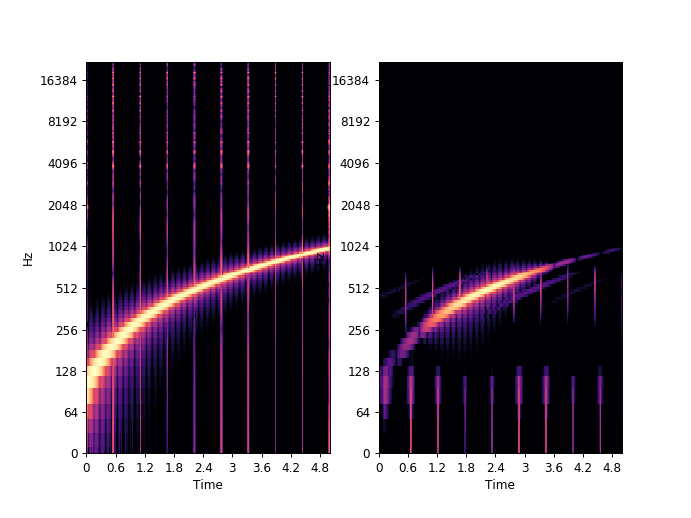

In [23]:
y = np.zeros_like(source)
for f, L in zip(*create_filters(filter_stack)):
    #y += frequency_method(source, f, L)
    y += window_method_v2(source, f, L)
    print(y)
compare_wave_spectra(source, y)
sf.write("chirp_100Hz_1000Hz_lin_filtered_chunks.wav", y, f_s)
Audio(y, rate=f_s)


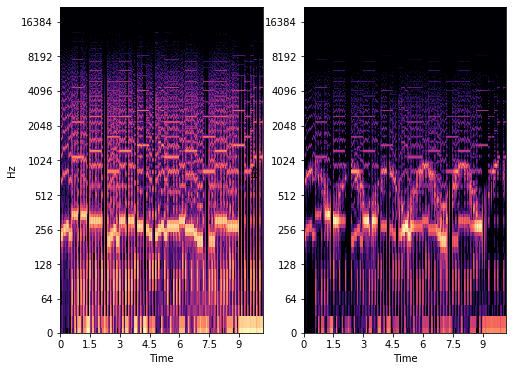

In [39]:
%matplotlib inline
source, f_s = sf.read("melody.wav", dtype='float64')
band_start = 600
band = band_start
chunk_size = 8 * 1024
hop_size = chunk_size//2
out = np.zeros_like(source)
L = 501
i = 0

for chunk, begin in chunks(source, chunk_size=chunk_size, hop_size=hop_size):
    
    band = band_start + band_start * 0.5 * np.sin(2 * np.pi * i/20)
    #print(band - 100, band + 100)
    nfilt = np.arange(-(L-1)/2, (L-1)/2 + 1) + 1e-9
    H = ideal_bandpass(nfilt, band - 100, band + 100, f_s)
    N = len(chunk) + L - 1
    H *= hann(len(H))

    padded_chunk = np.pad(chunk, (N - len(chunk), 0), 'constant', constant_values=(0, 0))
    padded_h = np.pad(H, (N - L, 0), 'constant', constant_values=(0, 0))

    window_spectrum = fft.fft(padded_chunk)[:len(padded_chunk)]
    h_spectrum = fft.fft(padded_h)

    product = window_spectrum * h_spectrum
    inverse = fft.ifft(product, len(padded_chunk)).real 
    out[begin : begin + len(inverse)] += inverse[:len(out[begin : begin + len(inverse)])]
    i += 1

mix = 0.1 * source + 0.9 * out
compare_wave_spectra(source, mix)
Audio(mix, rate = f_s)